In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load "../A1/MDP.py"
import numpy as np

class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self,T,R,discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount
        
    def valueIteration(self,initialV,nIterations=np.inf,tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''
        
        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while (iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_matrix = []
          for i in range(self.nActions):
            V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
          V_next = np.amax(np.array(V_matrix), 0)
          epsilon = np.max(np.abs(V_next - V))
          V = V_next
          
        return [V,iterId,epsilon]
          

    def extractPolicy(self,V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = np.zeros(self.nStates)
        
        V_matrix = []
        for i in range(self.nActions):
          V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
        policy = np.array(V_matrix).argmax(0)

        return policy 

    def evaluatePolicy(self,policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.zeros(self.nStates)
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
        
        V = np.linalg.pinv(np.identity(self.nStates) - self.discount*T_pi) @ R_pi

        return V
        
    def policyIteration(self,initialPolicy,nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = np.zeros(self.nStates)
        iterId = 0
        
        while(iterId < nIterations):
          iterId += 1
          V = self.evaluatePolicy(policy)
          policy_next = self.extractPolicy(V)
          if np.array_equal(policy, policy_next):
            return [policy,V,iterId]
          policy = policy_next
          
        return [policy, V, iterId]
          
    def evaluatePolicyPartially(self,policy,initialV,nIterations=np.inf,tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
          
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_next = R_pi + self.discount*T_pi @ V
          epsilon = np.max(np.abs(V_next - V))
          V = V_next

        return [V,iterId,epsilon]

    def modifiedPolicyIteration(self,initialPolicy,initialV,nEvalIterations=5,nIterations=np.inf,tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          [V, _, _] = self.evaluatePolicyPartially(policy,V,nEvalIterations,tolerance=0.01)
          policy = self.extractPolicy(V)
          [V_next, _, _] = self.valueIteration(V,1)
          epsilon = np.max(np.abs(V_next - V))
          

        return [policy,V,iterId,epsilon]

In [3]:
# %load "RL2.py"
import numpy as np

class RL2:
    def __init__(self,mdp,sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def sampleSoftmaxPolicy(self,policyParams,state):
        '''Procedure to sample an action from stochastic policy
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))])
        This function should be called by reinforce() to selection actions

        Inputs:
        policyParams -- parameters of a softmax policy (|A|x|S| array)
        state -- current state

        Outputs: 
        action -- sampled action
        '''

        # temporary value to ensure that the code compiles until this
        # function is coded
        pi = policyParams[:,state]
        pi = pi - np.max(pi)
        pi = np.exp(pi) / np.sum(np.exp(pi))
        action = np.where(np.cumsum(pi) >= np.random.rand(1))[0][0]
                          
        return action

    def modelBasedRL(self,s0,defaultT,initialR,nEpisodes,nSteps,epsilon=0):
        '''Model-based Reinforcement Learning with epsilon greedy 
        exploration.  This function should use value iteration,
        policy iteration or modified policy iteration to update the policy at each step

        Inputs:
        s0 -- initial state
        defaultT -- default transition function when a state-action pair has not been vsited
        initialR -- initial estimate of the reward function
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random

        Outputs: 
        V -- final value function
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        count_triple = np.ones([self.mdp.nActions, self.mdp.nStates, self.mdp.nStates])
        cumu_reward_lst = np.zeros(nEpisodes)
        V = np.zeros(self.mdp.nStates)
        policy = np.zeros(self.mdp.nStates,int)
        mdp_tmp = MDP(defaultT, initialR, self.mdp.discount)
        
        for iterEp in range(nEpisodes):
            state = s0
            for iterSt in range(nSteps):
                action = 0
                if np.random.rand(1) < epsilon:
                    action = np.random.randint(self.mdp.nActions)
                else:
                    action = policy[state]
                [reward, nextState] = self.sampleRewardAndNextState(state,action)
                cumu_reward_lst[iterEp] += self.mdp.discount**iterSt * reward
                count_triple[action,state,nextState] += 1
                count_double = np.sum(count_triple[action,state,:])
                mdp_tmp.T[action,state,:] = count_triple[action,state,:] /  count_double
                mdp_tmp.R[action, state] = (reward + (count_double-1) * mdp_tmp.R[action,state]) / count_double
                [policy, V, iterId] = mdp_tmp.policyIteration(policy)
                state = nextState
        return [V,policy,cumu_reward_lst] 

    def epsilonGreedyBandit(self,nIterations):
        '''Epsilon greedy algorithm for bandits (assume no discount factor)

        Inputs:
        nIterations -- # of arms that are pulled

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        empiricalMeans = np.zeros(self.mdp.nActions)
        count_lst = np.zeros(self.mdp.nActions)
        state = 0
        cumulative_reward = []
        
        for IterId in range(nIterations):
            epsilon = 1 / (IterId + 1)
            action = 0
            if (np.random.rand(1)[0] < epsilon):
                action = np.random.randint(self.mdp.nActions)
            else:
                action = np.argmax(empiricalMeans)
            [reward, _] = self.sampleRewardAndNextState(state,action)
            cumulative_reward.append(reward)
            empiricalMeans[action] = (count_lst[action] * empiricalMeans[action] + reward) / (count_lst[action] + 1)
            count_lst[action] += 1

        return [empiricalMeans, cumulative_reward]

    def thompsonSamplingBandit(self,prior,nIterations,k=1):
        '''Thompson sampling algorithm for Bernoulli bandits (assume no discount factor)

        Inputs:
        prior -- initial beta distribution over the average reward of each arm (|A|x2 matrix such that prior[a,0] is the alpha hyperparameter for arm a and prior[a,1] is the beta hyperparameter for arm a)  
        nIterations -- # of arms that are pulled
        k -- # of sampled average rewards

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        empiricalMeans = np.zeros(self.mdp.nActions)
        count_lst = np.zeros(self.mdp.nActions)
        state = 0
        Prior = prior
        cumulative_reward = []
        
        def Beta(theta):
            return np.random.beta(*theta)
            
        for IterId in range(nIterations):
            sample = np.apply_along_axis(Beta, 1, Prior)
            action = np.argmax(sample)
            [reward, _] = self.sampleRewardAndNextState(state,action)
            cumulative_reward.append(reward)
            Prior[action][1-reward] += 1
            empiricalMeans[action] = (count_lst[action] * empiricalMeans[action] + reward) / (count_lst[action] + 1)
            count_lst[action] += 1
            

        return [empiricalMeans, cumulative_reward]

    def UCBbandit(self,nIterations):
        '''Upper confidence bound algorithm for bandits (assume no discount factor)

        Inputs:
        nIterations -- # of arms that are pulled

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        empiricalMeans = np.zeros(self.mdp.nActions)
        count_lst = np.zeros(self.mdp.nActions)
        state = 0
        cumulative_reward = []
        
        def UCB_help(reward, n_total, n_action):
            if n_total is 0 or n_action is 0:
                return np.inf
            else:
                return reward + np.sqrt(2*np.log(n_total) / n_action)
        
        for IterId in range(nIterations):
            ucb_lst = []
            for i in range(self.mdp.nActions):
                ucb_lst.append(UCB_help(empiricalMeans[i], IterId, count_lst[i]))
            action = np.argmax(ucb_lst)
            [reward, _] = self.sampleRewardAndNextState(state,action)
            cumulative_reward.append(reward)
            empiricalMeans[action] = (count_lst[action] * empiricalMeans[action] + reward) / (count_lst[action] + 1)
            count_lst[action] += 1
        
        return [empiricalMeans, cumulative_reward]

    def reinforce(self,s0,initialPolicyParams,nEpisodes,nSteps):
        '''reinforce algorithm.  Learn a stochastic policy of the form
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))]).
        This function should call the function sampleSoftmaxPolicy(policyParams,state) to select actions

        Inputs:
        s0 -- initial state
        initialPolicyParams -- parameters of the initial policy (array of |A|x|S| entries)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0)
        nSteps -- # of steps per episode

        Outputs: 
        policyParams -- parameters of the final policy (array of |A|x|S| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policyParams = initialPolicyParams
        cumu_reward_lst = []
        count_lst = np.zeros([self.mdp.nActions, self.mdp.nStates])
        
        for iterEp in range(nEpisodes):
            G = np.zeros(nSteps)
            state = s0
            state_lst = []
            action_lst = []
            reward_lst = []
            for iterSt in range(nSteps):
                action = self.sampleSoftmaxPolicy(policyParams, state)
                [reward, next_state] = self.sampleRewardAndNextState(state, action)
                state_lst.append(state)
                action_lst.append(action)
                reward_lst.append(reward)
                state = next_state
            G[-1] = reward_lst[-1]
            for iter in range(nSteps-2, -1, -1):
                G[iter]=G[iter+1]*self.mdp.discount+reward_lst[iter]
            cumu_reward_lst.append(G[0])
            for iter in range(nSteps):
                count_lst[action_lst[iter], state_lst[iter]] += 1
                pi = policyParams[:,state_lst[iter]]
                pi -= np.max(pi)
                pi = np.exp(pi)
                pi = pi / np.sum(pi)
                gradient = -pi
                gradient[action_lst[iter]] += 1
                policyParams[:,state_lst[iter]] += 0.01 * (self.mdp.discount ** iter) * G[iter] * gradient
        return policyParams, cumu_reward_lst   

    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=1):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with 
        probabilty epsilon and performing Boltzmann exploration otherwise.  
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        Q = initialQ
        n_table = np.zeros(Q.shape,dtype=int)
        learning_rate = 0
        episodeId = 0
        reward_episodes = []
        while (episodeId < nEpisodes):
          episodeId += 1
          s=s0
          reward_cum=0
          stepId = 0
          discount_factor = 1
          while (stepId < nSteps):
            stepId += 1
            action = 0
            discount_factor *= self.mdp.discount
            if (np.random.rand(1) < epsilon):
              action = np.random.randint(self.mdp.nActions)
            elif (temperature != 0):
              boltz_state = np.exp(Q[:,s].flatten() / temperature)
              boltz_state = boltz_state / boltz_state.sum()
              boltz_state = np.cumsum(boltz_state)
              action = np.where(boltz_state >= np.random.rand(1))[0][0]
            else:
              action = Q[:,s].argmax()
            [reward, s_next] = self.sampleRewardAndNextState(s,action)
            n_table[action,s] += 1
            learning_rate = 1 / n_table[action,s]
            Q[action,s] = Q[action,s] + learning_rate*(reward + self.mdp.discount*np.max(Q[:,s_next].flatten())-Q[action,s])
            s = s_next
            reward_cum += discount_factor * reward
          reward_episodes.append(reward_cum)
        
        policy = Q.argmax(0).flatten()

        return [Q,policy, reward_episodes]    

/home/haobei/.conda/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in double_scalars
/home/haobei/.conda/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: divide by zero encountered in double_scalars


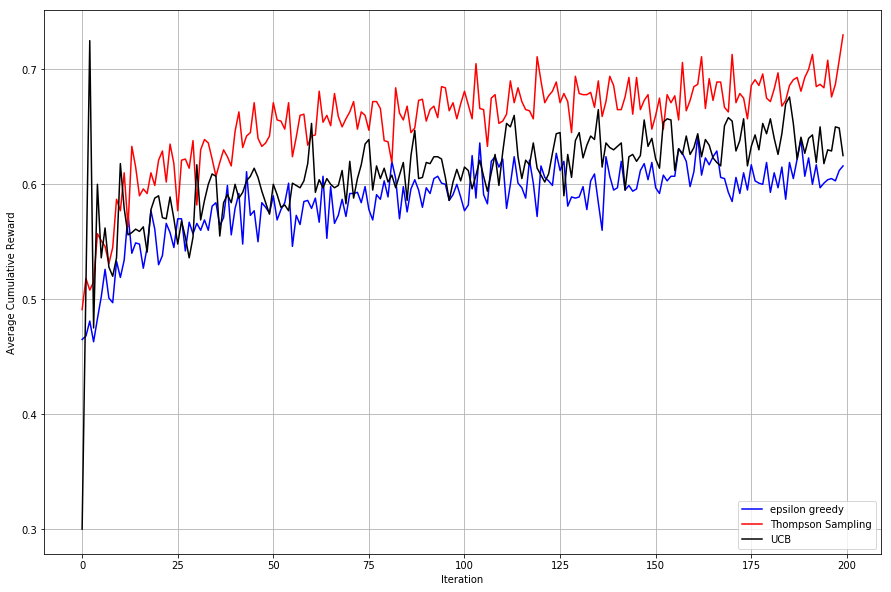

In [4]:
# %load "TestRL2.py"
import numpy as np


def sampleBernoulli(mean):
    ''' function to obtain a sample from a Bernoulli distribution

    Input:
    mean -- mean of the Bernoulli
    
    Output:
    sample -- sample (0 or 1)
    '''

    if np.random.rand(1) < mean: return 1
    else: return 0


# Multi-arm bandit problems (3 arms with probabilities 0.3, 0.5 and 0.7)
T = np.array([[[1]],[[1]],[[1]]])
R = np.array([[0.3],[0.5],[0.7]])
discount = 0.999
mdp = MDP(T,R,discount)
banditProblem = RL2(mdp,sampleBernoulli)

epsilon_lst = []
Thompson_lst = []
UCB_lst = []
for i in range(1000):
# Test epsilon greedy strategy
    [empiricalMeans, cumulative_reward] = banditProblem.epsilonGreedyBandit(nIterations=200)
    epsilon_lst.append(cumulative_reward)

# Test Thompson sampling strategy
    [empiricalMeans, cumulative_reward] = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=200)
    Thompson_lst.append(cumulative_reward)

# Test UCB strategy
    [empiricalMeans, cumulative_reward] = banditProblem.UCBbandit(nIterations=200)
    UCB_lst.append(cumulative_reward)
epsilon_lst = np.mean(epsilon_lst,axis=0)
Thompson_lst = np.mean(Thompson_lst,axis=0)
UCB_lst = np.mean(UCB_lst,axis=0)

plt.figure(figsize=(15,10))
_=plt.plot(range(200),epsilon_lst,'-b', label='epsilon greedy')
_=plt.plot(range(200),Thompson_lst, '-r', label='Thompson Sampling')
_=plt.plot(range(200),UCB_lst, '-k', label='UCB')
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Average Cumulative Reward")
plt.legend()
plt.show()


REINFORCE results
[[ 4.53246446e-07 -2.76256983e+00  4.51546090e-07 -3.37561952e+00]
 [-2.72066546e+00  7.29377620e-09 -1.97854717e+00  2.56315387e-07]]

model-based RL results
[30.53546734 37.29580036 42.27773832 52.41609355]
[0 1 1 1]

qLearning results
[0 1 1 1]


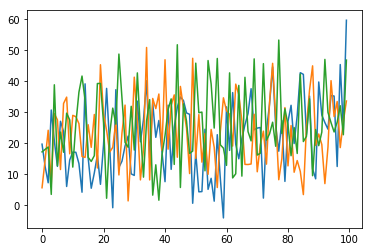

In [5]:
''' Construct simple MDP as described in Lecture 2a Slides 13-14'''
T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
R = np.array([[0,0,10,10],[0,0,10,10]])
discount = 0.9        
mdp = MDP(T,R,discount)
rlProblem = RL2(mdp,np.random.normal)
# Test REINFORCE 
policy,cumu_reward = rlProblem.reinforce(s0=0,initialPolicyParams=np.random.rand(mdp.nActions,mdp.nStates),nEpisodes=100,nSteps=100)
print ("\nREINFORCE results")
print (policy)
plt.plot(list(range(100)), cumu_reward)

# Test model-based RL
[V,policy,cumu_reward] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=100,nSteps=100,epsilon=0.3)
print ("\nmodel-based RL results")
print (V)
print (policy)
plt.plot(list(range(100)), cumu_reward)

[Q,policy,cumu_reward] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=100,nSteps=100,epsilon=0.05,temperature=1)
print ("\nqLearning results")
print (policy)
_=plt.plot(list(range(100)), cumu_reward)
plt.show()


In [6]:
# %load "TestRL2Maze.py"


''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL2(mdp,np.random.normal)

# Test REINFORCE 




REINFORCE results
V:  [ 56.70551326  61.23512344  66.03866417  70.22230926  58.63806583
  63.3127929   72.39555835  79.93849108  56.91074804  33.37844875
  77.31276634  89.67429333  60.74705344  66.25833568  79.54402104
 100.05954056   4.72404272]
Policy:  [[-5.10436498e+00 -1.55160919e+00 -5.77475869e+00 -3.49800793e+00
  -7.36954196e+00 -3.54424513e+00 -4.31975617e+00 -5.75969067e+00
  -7.61050002e-01 -2.07537270e+00 -2.24254767e+00 -4.46821779e+00
  -2.74912067e+00 -3.35405836e+00 -1.81482968e+00 -2.39953849e+00
  -1.41640292e+00]
 [-7.01689243e+00 -3.12243203e-01  7.87140735e-03  1.42623393e-01
  -4.78192126e+00 -4.73886268e+00 -5.28489340e+00  6.80512633e-03
   2.87294896e-01 -5.88770558e-05  8.02336598e-02  1.53636977e-02
  -2.85485028e+00 -3.03028999e+00 -2.52391338e+00 -6.35090938e-01
  -1.84731093e+00]
 [-3.78729869e+00 -3.49465117e+00 -5.26408961e+00 -3.49960327e+00
  -5.21756871e+00 -2.99858687e+00 -5.02159056e+00 -5.71817375e+00
  -1.85599278e+00 -1.16036791e+00 -3.9571233

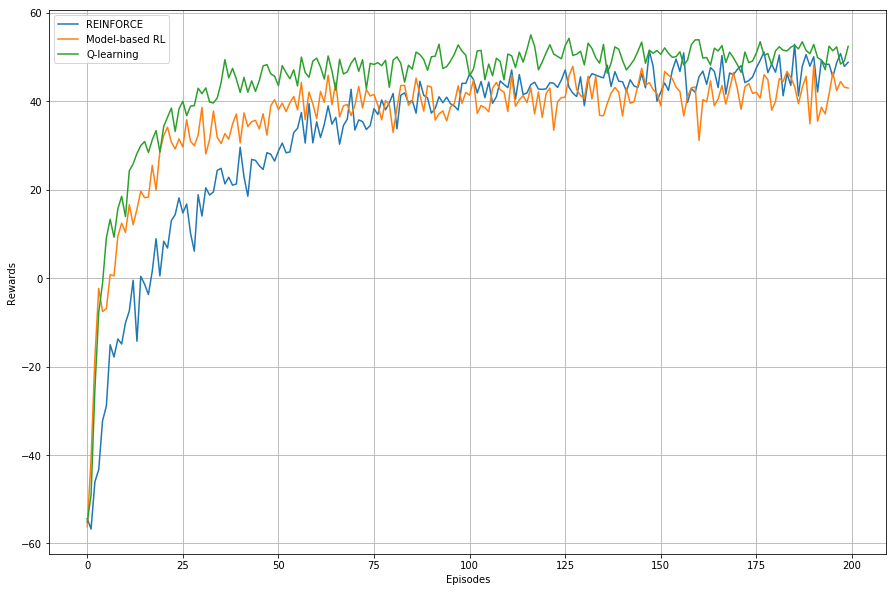

In [8]:
Trials = 100

# Test model-based RL
cumu_ma = []
start_time = time.time()
for iterTr in range(Trials):
    policy,cumu_reward = rlProblem.reinforce(s0=0,initialPolicyParams=np.random.rand(mdp.nActions,mdp.nStates),nEpisodes=200,nSteps=100)
    cumu_ma.append(cumu_reward)

print ("\nREINFORCE results")
print ("V: ", V)
print ("Policy: ", policy)
print ("Time taken for each trial: ", (time.time() - start_time)/200)
plt.figure(figsize=(15,10))
plt.grid()
plt.plot(list(range(200)), np.mean(cumu_ma,axis=0),label="REINFORCE")
plt.xlabel("Episodes")
plt.ylabel("Rewards")

# Test model-based RL
cumu_ma = []
start_time = time.time()
for iterTr in range(Trials):
    [V,policy,cumu_reward] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3)
    cumu_ma.append(cumu_reward)
print ("\nmodel-based RL results")
print ("V: ", V)
print ("Policy: ", policy)
print ("Time taken for each trial: ", (time.time() - start_time)/200)
plt.plot(list(range(200)), np.mean(cumu_ma,axis=0), label="Model-based RL")

# Test Q-learning
cumu_ma = []
start_time = time.time()
for iterTr in range(Trials):
    [Q,policy,cumu_reward] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05,temperature=1)
    cumu_ma.append(cumu_reward)
print ("\nQ-learning results")
print ("Q: ", Q)
print ("Policy: ", policy)
print ("Time taken for each trial: ", (time.time() - start_time)/200)
plt.plot(list(range(200)), np.mean(cumu_ma,axis=0), label="Q-learning")
plt.legend()
plt.show()